# Using Little VGG for Emotion Detection

## Explore the dataset

* print the labels of all classes
* print the number of images in each class for training and validation
* Visualize a randome image from each class

In [1]:
import os
# Print the label of all classes
print("Labels of Emotion Classes: ")
for i, lab in enumerate(os.listdir('./fer2013/train')):
    print(str(i+1) + ": " + lab)

Labels of Emotion Classes: 
1: Neutral
2: Angry
3: Fear
4: Happy
5: Surprise
6: Sad


**Check number of images in each classes**

Total number of images in training:  28273
Total number of images in validation:  3534


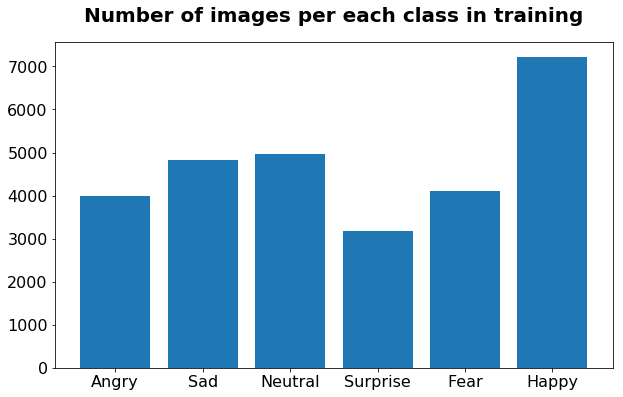

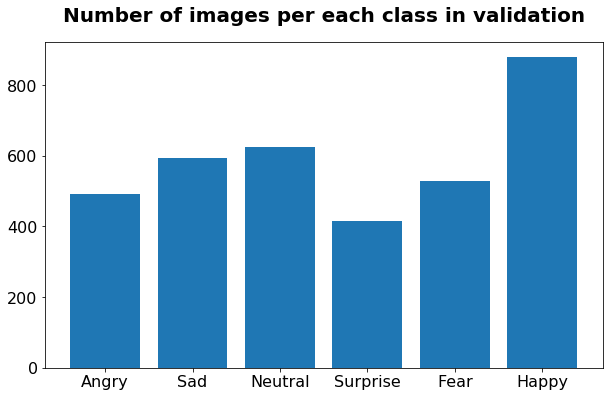

In [2]:
%matplotlib inline
import os
import matplotlib.pyplot as plt

image_stats_train = {}
image_stats_val = {}

# number of images in train folder
for label in os.listdir('./fer2013/train'):
    label_path = os.path.join('./fer2013/train', label)
    image_stats_train[label] = len([image for image in os.listdir(label_path) 
                                  if os.path.isfile(os.path.join(label_path, image))])
# number of images in train folder
for label in os.listdir('./fer2013/validation'):
    label_path = os.path.join('./fer2013/validation', label)
    image_stats_val[label] = len([image for image in os.listdir(label_path) 
                                  if os.path.isfile(os.path.join(label_path, image))])

# Helper function to plot number of images per each class
def plot_image_stats(image_stats, title):
    plt.figure(figsize=(10,6))
    plt.bar(range(len(image_stats)), image_stats.values(), align='center')
    plt.xticks(range(len(image_stats)), image_stats.keys(),fontsize=16)
    plt.yticks(fontsize=16)
    plt.title(title, fontsize=20, fontweight='bold', pad=20)

print "Total number of images in training: ", sum(image_stats_train.values())
print "Total number of images in validation: ", sum(image_stats_val.values()) 
plot_image_stats(image_stats_train, 'Number of images per each class in training')
plot_image_stats(image_stats_val, 'Number of images per each class in validation')


**Visualize random images from each class**

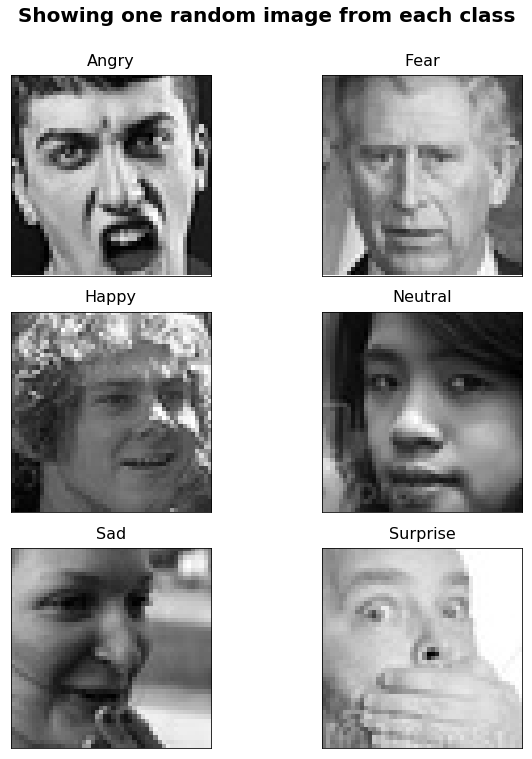

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Visualize the data, showing one image per class from 6 classes
rows = 3
cols = 2
fig, ax = plt.subplots(rows, cols, figsize=(10,10))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=20, fontweight='bold')
train_dir = './fer2013/train'
label_sorted = sorted(os.listdir(train_dir))
label_id = 0
for i in range(rows):
    for j in range(cols):
        label = label_sorted[label_id]
        label_selected_images = os.listdir(os.path.join(train_dir, label))
        label_selected_random = np.random.choice(label_selected_images)
        img = plt.imread(os.path.join(train_dir, label, label_selected_random),0)
        ax[i][j].imshow(img, cmap='gray')
        ax[i][j].set_title(label, pad = 10,fontsize=16)
        label_id += 1
        
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout()
plt.show()

## Import dataset and generate data augmentation

In [6]:
from __future__ import print_function
import keras
from keras.preprocessing.image import ImageDataGenerator
import os

num_classes = 6
img_rows, img_cols = 48, 48
batch_size = 16

train_data_dir = './fer2013/train'
validation_data_dir = './fer2013/validation'

# Let's use some data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='grayscale', # need to specify colormode when training on grayscale images
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)



/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 28273 images belonging to 6 classes.
Found 3534 images belonging to 6 classes.


## Build a Little VGG models

In [7]:
# Import Keras models and layers
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU

# create a downsize version of VGG
model = Sequential()

# Block #1: first CONV => ELU => CONV => ELU => POOL
# layer set
model.add(Conv2D(32,(3,3), padding='same', kernel_initializer="he_normal",
                 input_shape = (img_rows, img_cols, 1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3), padding='same', kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block #2: second CONV => ELU => CONV => ELU => POOL
# layer set
model.add(Conv2D(64,(3,3), padding='same', kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), padding='same', kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block #3: third CONV => ELU => CONV => ELU => POOL
# layer set
model.add(Conv2D(128,(3,3), padding='same', kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), padding='same', kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block #4: fourth CONV => ELU => CONV => ELU => POOL
# layer set
model.add(Conv2D(256,(3,3), padding='same', kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3), padding='same', kernel_initializer="he_normal"))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block #5: first set of FC => ELU layers
model.add(Flatten())
model.add(Dense(64, kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #6: Second set of FC => ELU layers
model.add(Dense(64, kernel_initializer='he_normal'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Block #7: softmax classifier
model.add(Dense(num_classes, kernel_initializer='he_normal'))
model.add(Activation('softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
__________

## Training our model

In [8]:
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# create callbacks for our model
checkpoint = ModelCheckpoint('./Trained Models/emotion_little_vgg_3.h5',
                            monitor='val_loss',
                            mode="min",
                            save_best_only=True,
                            verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                         min_delta=0,
                         patience=3,
                         verbose=1)
                         # restore_best_weights=True) # This feature is only updated in Keras >= 2.2.2
                                                    # keras version in this machine is 2.1.2
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.2,
                             patience=3,
                             verbose=1,
                             min_delta=0.0001)

callbacks =[checkpoint, earlystop, reduce_lr]

# compile model using a small learning rate
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.001),
             metrics = ['accuracy'])

nb_train_samples = 28273
nb_validation_samples = 3534
epochs = 30

# Fit out model
history = model.fit_generator(train_generator,
                   steps_per_epoch=nb_train_samples//batch_size,
                   epochs = epochs,
                   callbacks=callbacks,
                   validation_data=validation_generator,
                   validation_steps= nb_validation_samples // batch_size)

Epoch 1/30
1767/1767 [==============================] - 94s 53ms/step - loss: 1.9341 - acc: 0.2097 - val_loss: 1.7446 - val_acc: 0.2503

Epoch 00001: val_loss improved from inf to 1.74465, saving model to ./Trained Models/emotion_little_vgg_3.h5
Epoch 2/30
1767/1767 [==============================] - 42s 24ms/step - loss: 1.7471 - acc: 0.2465 - val_loss: 1.7211 - val_acc: 0.2679

Epoch 00002: val_loss improved from 1.74465 to 1.72113, saving model to ./Trained Models/emotion_little_vgg_3.h5
Epoch 3/30
1767/1767 [==============================] - 38s 21ms/step - loss: 1.7385 - acc: 0.2563 - val_loss: 1.6796 - val_acc: 0.2974

Epoch 00003: val_loss improved from 1.72113 to 1.67955, saving model to ./Trained Models/emotion_little_vgg_3.h5
Epoch 4/30
1767/1767 [==============================] - 38s 22ms/step - loss: 1.7103 - acc: 0.2747 - val_loss: 1.6691 - val_acc: 0.3114

Epoch 00004: val_loss improved from 1.67955 to 1.66911, saving model to ./Trained Models/emotion_little_vgg_3.h5
Epoc

## Confusion matrix and Classification report

Found 3534 images belonging to 6 classes.


Confusion Matrix
[[211  29  13  46 175  17]
 [139  70  13  82 136  88]
 [ 35   8 718  41  51  26]
 [ 96  41 131 121 165  72]
 [ 53  24  30 117 362   8]
 [ 19  49  21  19  14 294]]


Classification Report
             precision    recall  f1-score   support

      Angry       0.38      0.43      0.40       491
       Fear       0.32      0.13      0.19       528
      Happy       0.78      0.82      0.80       879
    Neutral       0.28      0.19      0.23       626
        Sad       0.40      0.61      0.48       594
   Surprise       0.58      0.71      0.64       416

avg / total       0.48      0.50      0.48      3534



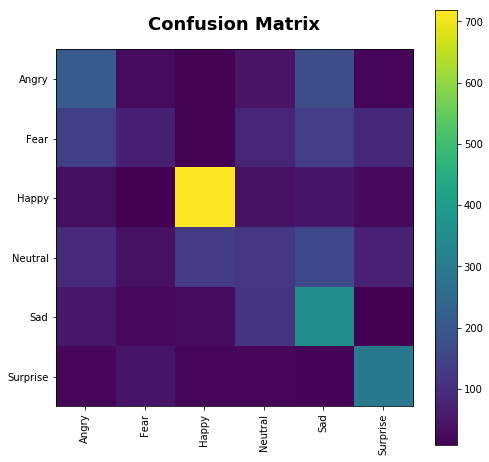

In [12]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

nb_train_samples = 28273
nb_validation_samples = 3534

# Need to recreate validation generator with shuffle = False
validation_data_dir = './fer2013/validation'
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator= validation_datagen.flow_from_directory(
    validation_data_dir,
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v:k for k, v in class_labels.items()}
classes = list(class_labels.values())

# Confusion matrix and classification report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('\n\nConfusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('\n\nClassification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names = target_names))

# Visualize confusion matrix
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(8,8))
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix', fontsize=18, fontweight='bold', pad = 20)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)


### Comments:
* The model is doing quite well at recognizing 'Happy'. On the other hand, the performance of detecting 'Fear' is quite bad

## Testing on some of validation images

**Load our saved model**

In [16]:
from keras.models import load_model
classifier = load_model('./Trained Models/emotion_little_vgg_3.h5', compile = False)

**Get our class labels**


In [23]:
# need to re-create validation generator with shuffle = False
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    color_mode = 'grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v:k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(class_labels)

Found 3534 images belonging to 6 classes.
{0: 'Angry', 1: 'Fear', 2: 'Happy', 3: 'Neutral', 4: 'Sad', 5: 'Surprise'}


**Test on some validation images**

10


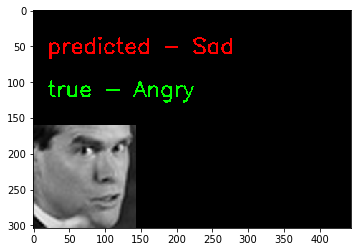

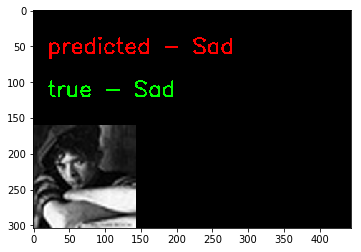

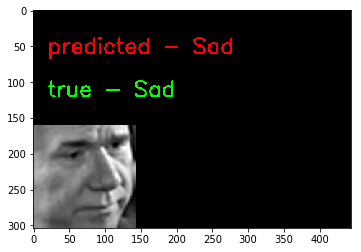

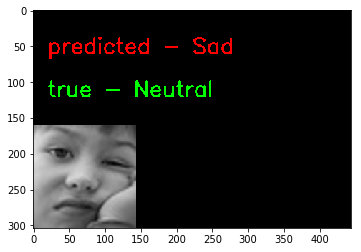

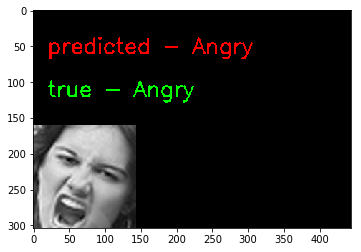

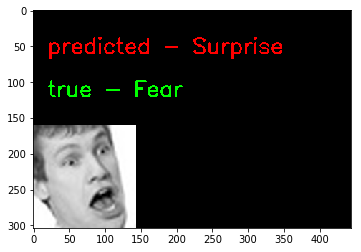

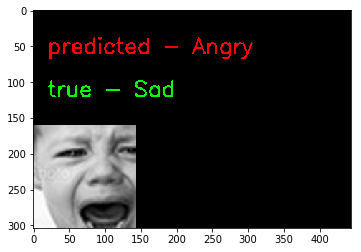

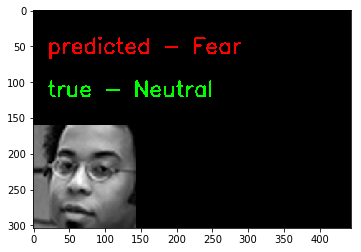

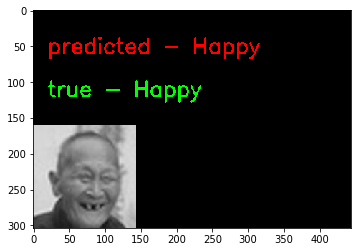

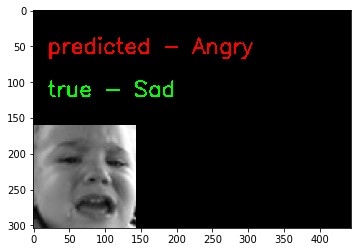

In [28]:
from keras.models import load_model
from keras.optimizers import RMSprop, SGD, Adam
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from os import listdir
from os.path import isfile, join
import re

def draw_test(name, pred, img, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(img, 160, 0,0,300, cv2.BORDER_CONSTANT, value=BLACK)
    cv2.putText(expanded_image, "predicted - " + pred, (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0),2)
    cv2.putText(expanded_image, "true - " + true_label, (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255,0),2)
    plt.imshow(expanded_image)
    
def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path,x)), os.listdir(path)))
    random_dir = np.random.randint(0, len(folders))
    path_class = folders[random_dir]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0, len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size=(img_width, img_height), grayscale=True), final_path, path_class
 
# dimensions of images
img_width, img_height = 48,48

# use a small learning rate
model.compile(loss='categorical_crossentropy',
             optimizer=RMSprop(lr=0.001),
             metrics=['accuracy'])

files = []
predictions = []
true_labels = []

# select randome images and draw test on them
for i in range(0, 10):
    path = './fer2013/validation/'
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x*1./255
    x = np.expand_dims(x, axis=0) # axis=0: Position in the expanded axes where the new axis is placed.
    images = np.vstack([x]) # Stack arrays in sequence vertically (row wise)
    classes = classifier.predict_classes(images, batch_size=10)
    predictions.append(classes)
    
print(len(files))
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    image = cv2.resize(image, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    plt.show()

## Combine our classifier with Haar Cascade Classifier to detect Face and Emotion

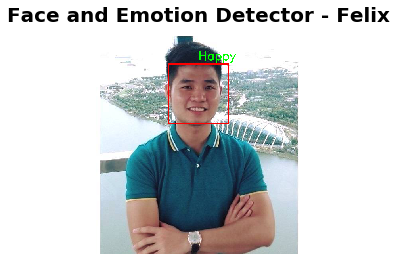

In [42]:
import numpy as np
from os import listdir
from os.path import isfile, join
from keras.preprocessing.image import img_to_array

face_classifier = cv2.CascadeClassifier('./Haarcascades/haarcascade_frontalface_default.xml')

def face_detector(img):
    #convert image to grayscale
    gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3,5) # parameter to twist the sensitivity
    if faces is ():
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    allfaces = []
    rects = []
    for (x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w] # crop the faces out of image
        roi_gray = cv2.resize(roi_gray, (48,48), interpolation=cv2.INTER_AREA)
        allfaces.append(roi_gray)
        rects.append((x, w,y,h))
    return rects, allfaces, img

img = plt.imread("felix.jpg")
#cv2.imshow('felix', img)
#cv2.waitKey()
# cv2.destroyAllWindows()

rects, faces, image = face_detector(img)

i = 0
for face in faces:
    roi = face.astype("float")/255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    
    # make a prediction on the ROI, then loopup the class
    preds = classifier.predict(roi)[0]
    label = class_labels[preds.argmax()]
    
    # Overlay our detected emotion on picture
    label_position = (rects[i][0] + int((rects[i][1]/2)), abs(rects[i][2] - 10))
    i =+ 1
    cv2.putText(img, label, label_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),2)
    
plt.imshow(img, interpolation='nearest')
plt.title("Face and Emotion Detector - Felix", fontsize=20, fontweight='bold', pad = 15)
plt.axis('off')
plt.show()
    

## Test the Face and Emotion detector on a video

In [58]:
import cv2
import numpy as np
from time import sleep
from keras.preprocessing.image import img_to_array

face_classifier = cv2.CascadeClassifier('./Haarcascades/haarcascade_frontalface_default.xml')

def face_detector(img):
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    if faces is ():
        return (0,0,0,0), np.zeros((48,48), np.uint8), img
    
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]

    try:
        roi_gray = cv2.resize(roi_gray, (48, 48), interpolation = cv2.INTER_AREA)
    except:
        return (x,w,y,h), np.zeros((48,48), np.uint8), img
    return (x,w,y,h), roi_gray, img

cap = cv2.VideoCapture('walking.avi')
print(cap.isOpened())
success = True
# while cap.isOpened():
while success:
    print("start")
    # time.sleep(0.05)
    ret, frame = cap.read()
    #frame1 = frame.astype('uint8')
    #plt.imshow(frame1)
    rect, face, image = face_detector(frame)
    if np.sum([face]) != 0.0:
        roi = face.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        # make a prediction on the ROI, then lookup the class
        preds = classifier.predict(roi)[0]
        label = class_labels[preds.argmax()]  
        label_position = (rect[0] + int((rect[1]/2)), rect[2] + 25)
        cv2.putText(image, label, label_position , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
    else:
        cv2.putText(image, "No Face Found", (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,2, (0,255,0), 3)
        
    plt.imshow(image)
    plt.show()
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break

cap.release()
#cv2.destroyAllWindows() 

False
start


error: OpenCV(3.4.1) /root/opencv/modules/imgproc/src/color.cpp:11147: error: (-215) scn == 3 || scn == 4 in function cvtColor


In [ ]:
print 

In [ ]:
# Initiate video capture for video file
cap = cv2.VideoCapture('images/cars.avi')


# Loop once video is successfully loaded
while cap.isOpened():
    
    time.sleep(.05)
    # Read first frame
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
   
    # Pass frame to our car classifier
    cars = car_classifier.detectMultiScale(gray, 1.4, 2)
    
    # Extract bounding boxes for any bodies identified
    for (x,y,w,h) in cars:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)
        cv2.imshow('Cars', frame)

    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break

cap.release()
cv2.destroyAllWindows()

In [93]:
import dill
dill.dump_session('build_emotion_detector.db')

TypeError: can't pickle SwigPyObject objects